In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

In [3]:
import torch
from fastai.text import *
from pathlib import Path
import dill as pickle
from src.dataloader import PairedDataset, PairedEmbedDataset
from sklearn.model_selection import StratifiedShuffleSplit

DATA = Path('../data/')
LM = DATA/'language-model/'
CLS = DATA/'classifier/'
WT = DATA/'wt/models/wt103/'
TMP = DATA/'tmp'

### 1. Load data

In [5]:
# Tokenized text
qntok = np.load(CLS/'cls_trn.npy')
qnlabels = np.load(CLS/'cls_trn_lbl.npy').astype(np.float32)

# Split into training and validation sets.
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.1, random_state=0)
trn_idx, val_idx = next(iter(sss.split(qntok, qnlabels)))

trn, trn_lbl = qntok[trn_idx], qnlabels[trn_idx]
val, val_lbl = qntok[val_idx], qnlabels[val_idx]

# Load vocab
itos = pickle.load((DATA/'itos.p').open('rb'))
stoi = pickle.load((DATA/'stoi.p').open('rb'))
vs = len(itos)

In [6]:
# Make datasets and dataloaders
trn_ds = PairedDataset(trn, trn_lbl)
val_ds = PairedDataset(val, val_lbl)

# transpose_y is currently a hack to transpose the second question as well. Submit PR to fastai!
trn_dl = DataLoader(trn_ds, bs//2, num_workers=1, pad_idx=1, shuffle=True, transpose=True, 
                    transpose_y=True, pre_pad=False)
val_dl = DataLoader(val_ds, bs, num_workers=1, pad_idx=1, shuffle=False, transpose=True, 
                    transpose_y=True, pre_pad=False)

# Make model data
md = ModelData(TMP, trn_dl, val_dl)

In [ ]:
# Sample
*x,y = next(iter(trn_dl))
x[0].size(), x[1].size(), y.size()

### 2. Get Encoder

In [ ]:
# Config
wd = 1e-7
bptt = 70
bs = 48
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

# Dropout
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

# Load language model
ft_lm = to_gpu(get_language_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4]))
ft_lm.load('..')
ft_encoder = ft_lm[0]

### 3. Train model

In [15]:
class E2ESymmetricNet(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder
        
    def pool(self, x, bs, is_max):
        f = F.adaptive_max_pool1d if is_max else F.adaptive_avg_pool1d
        return f(x.permute(1,2,0), (1,)).view(bs, -1)
    
    def forward_once(self, inp):
        self.encoder.reset()
        raw_outputs, outputs = self.encoder(inp)
        output = outputs[-1]
        sl, bs, _ = output.size()
        avgpool = self.pool(output, bs, False)

        return output[-1]
    
    def forward(self, *input):        
        x1, x2 = self.forward_once(input[0]), self.forward_once(input[1])
        return torch.exp(-(x1 - x2).abs().sum(1))
    
    def freeze_encoder(self):
        enc = self.encoder
        enc.training = False
        for param in enc.parameters(): 
            param.requires_grad = False
            
    def unfreeze_encoder(self):
        enc = self.encoder
        enc.training = True
        for param in enc.parameters(): 
            param.requires_grad = True

In [17]:
# Make Learner
learn = Learner(md, SingleModel(E2ESymmetricNet(ft_encoder).cuda()), 
                crit=F.mse_loss, opt_fn=optim.Adam, metrics=[accuracy_thresh(0.5)])
learn.model.unfreeze_encoder()
learn.clip=0.25

In [18]:
wd=1e-7
learn.lr_find(1e-5, 5, wds=wd)

epoch      trn_loss   val_loss   <lambda>                          
    0      0.352894   0.365291   0.634687  



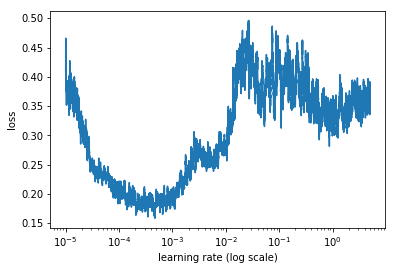

In [19]:
learn.sched.plot()

In [20]:
learn.fit(1e-3, 1, cycle_len=10, wds=wd, use_clr=(20, 10))

 18%|█▊        | 8277/45483 [15:31<1:11:39,  8.65it/s, loss=0.169]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 33%|███▎      | 14807/45483 [27:59<55:41,  9.18it/s, loss=0.187]  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 46%|████▋     | 21117/45483 [40:53<45:27,  8.93it/s, loss=0.159]  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 61%|██████    | 27701/45483 [53:13<34:03,  8.70it/s, loss=0.166]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



epoch      trn_loss   val_loss   <lambda>                          
    0      0.177286   0.166694   0.756099  
    1      0.155282   0.151198   0.783085                          
    2      0.155447   0.14315    0.797317                             
    3      0.135215   0.134182   0.809281                          
    4      0.126106   0.131003   0.816199                          
    5      0.11934    0.128975   0.817461                          
    6      0.129097   0.124911   0.823853                           
    7      0.099743   0.122613   0.827462                           
    8      0.111978   0.120179   0.832059                           
 67%|██████▋   | 30376/45483 [55:01<27:35,  9.12it/s, loss=0.101]   

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    9      0.104227   0.119319   0.834887                           



[array([0.11932]), 0.8348869027884517]

In [31]:
nn_evaluate(md.val_dl, learn.model)

Accuracy:  0.8335848029879542
Negative Log loss:  0.38575378046816444
             precision    recall  f1-score   support

        0.0       0.86      0.88      0.87     25503
        1.0       0.78      0.76      0.77     14926

avg / total       0.83      0.83      0.83     40429



In [32]:
learn.lr_find(1e-9, 2, wds=wd)

 76%|███████▋  | 34757/45483 [1:05:32<18:51,  9.48it/s, loss=0.294]  

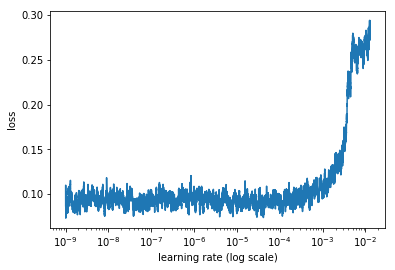

In [33]:
learn.sched.plot()

In [ ]:
learn.fit(1e-5, 1, cycle_len=10, wds=wd, use_clr=(20, 10))

  0%|          | 1/45483 [00:00<1:41:28,  7.47it/s, loss=0.0467]   
epoch      trn_loss   val_loss   <lambda>                           
    0      0.0817     0.119357   0.834726  
    1      0.089166   0.119577   0.834874                           
 29%|██▉       | 13098/45483 [23:05<58:55,  9.16it/s, loss=0.0903]  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 52%|█████▏    | 23630/45483 [41:36<37:49,  9.63it/s, loss=0.0852]  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 63%|██████▎   | 28732/45483 [50:37<30:56,  9.02it/s, loss=0.0889]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 69%|██████▉   | 31406/45483 [55:18<24:56,  9.41it/s, loss=0.0873]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 80%|████████  | 36517/45483 [1:04:17<15:34,  9.59it/s, loss=0.0988]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 87%|████████▋ | 39463/45483 [1:09:29<11:07,  9.02it/s, loss=0.0841]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 98%|█████████▊| 44562/45483 [1:18:30<01:36,  9.58it/s, loss=0.0997]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  3%|▎         | 1485/45483 [02:41<1:22:43,  8.86it/s, loss=0.0882]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 13%|█▎        | 5931/45483 [11:00<1:17:05,  8.55it/s, loss=0.0856]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 18%|█▊        | 8119/45483 [15:01<1:07:11,  9.27it/s, loss=0.0959]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 30%|███       | 13779/45483 [25:28<54:45,  9.65it/s, loss=0.101]   

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 45%|████▍     | 20283/45483 [37:29<46:34,  9.02it/s, loss=0.092]   

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 59%|█████▉    | 26978/45483 [49:58<33:59,  9.07it/s, loss=0.0873]  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 80%|███████▉  | 36261/45483 [1:07:08<17:05,  8.99it/s, loss=0.0961]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    3      0.086451   0.119861   0.834361                           
  3%|▎         | 1210/45483 [02:15<1:16:30,  9.64it/s, loss=0.11]  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 17%|█▋        | 7704/45483 [14:21<1:07:31,  9.32it/s, loss=0.0873]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 32%|███▏      | 14396/45483 [26:48<57:48,  8.96it/s, loss=0.088]   

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 47%|████▋     | 21252/45483 [39:20<45:57,  8.79it/s, loss=0.0916]  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 61%|██████    | 27825/45483 [51:37<31:51,  9.24it/s, loss=0.0822]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 76%|███████▌  | 34364/45483 [1:03:52<21:52,  8.47it/s, loss=0.0919]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 90%|█████████ | 40959/45483 [1:16:12<08:33,  8.82it/s, loss=0.0946]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    4      0.097393   0.119768   0.835045                           
  5%|▍         | 2190/45483 [04:04<1:14:42,  9.66it/s, loss=0.0891]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 20%|█▉        | 8935/45483 [16:34<1:05:29,  9.30it/s, loss=0.0955]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 54%|█████▍    | 24771/45483 [45:52<37:16,  9.26it/s, loss=0.0994]  